In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize, basinhopping, least_squares
from scipy.interpolate import interp1d
from numpy import pi, sin, cos, arcsin, dot
from statistics import mean

class ThinFilm_model:
    def __init__(self, ambient, thinfilm, substrate, wl, angle = 0):
        self.wavelength = wl
        self.ambient = chromatic_n(ambient['a'], self.wavelength)
        self.substrate = chromatic_n(substrate['s'], self.wavelength)
        self.thinfilm = thinfilm
        self.angle = angle*pi/180
        
    def eq_tf_matrix(self, pl):
        eq_matrix = identity_matrix(self.wavelength)
        for i in range(np.size(self.thinfilm)):
            eq_matrix = matrix_dot(
                tf_matrix(self.thinfilm[-i-1], self.wavelength, 
                          pl, self.ambient, self.angle), eq_matrix)
        return eq_matrix

    def eq_admittance(self, pl):
        eq_matrix = self.eq_tf_matrix(pl)
        theta_s = arcsin(self.ambient/self.substrate*sin(self.angle))
        if pl == "S":
            eq_y = bc(eq_matrix, self.substrate*cos(theta_s)/cos(self.angle), self.wavelength)
        elif pl == "P":
            eq_y = bc(eq_matrix, self.substrate*cos(self.angle)/cos(theta_s), self.wavelength)
        else:
            eq_y = bc(eq_matrix, self.substrate, wl)
        return eq_y
    
    def eq_Y(self, pl, rt):
        eq_y = self.eq_admittance(pl)
        if rt == "T":
            return eq_y
        elif rt == "R":
            Y = eq_y['C']/eq_y['B']
            return Y.values.reshape(np.size(self.wavelength), 1)
    
    def transmittance(self, pl):
        eq_y = self.eq_Y(pl, "T")
        t = (self.ambient*eq_y["B"]+eq_y["C"]).values
        T = 4*self.ambient*np.real(self.substrate)/(t*t.conjugate())
        return T
    
    def T(self, pl = None):
        if self.angle != 0:
            if pl == "S":
                return self.transmittance("S")
            elif pl == "P":
                return self.transmittance("P")
            else:
                T_S = self.transmittance("S")
                T_P = self.transmittance("P")
                return (T_S+T_P)/2
        else:
            return self.transmittance(None)
    
    def reflectance(self, pl):
        eq_Y = self.eq_Y(pl, "R").flatten()
        r = (self.ambient-eq_Y)/(self.ambient+eq_Y)
        reflectance = np.reshape(r*r.conjugate(), np.size(eq_Y))
        return np.real(reflectance)
    
    def R(self, pl = None):
        if self.angle != 0:
            if pl == "S":
                return self.reflectance("S")
            elif pl == "P":
                return self.reflectance("P")
            else:
                R_S = self.reflectance("S")
                R_P = self.reflectance("P")
                return (R_S+R_P)/2
        else:
            return self.reflectance(None)

def bc(eq, ns, wl):
    m = np.size(wl)
    ita_s = np.reshape(pd.DataFrame({"one":np.ones(m),"ita":ns}).values.reshape(-1, 1), (m, 2, 1))
    YY = [dot(eq[i], ita_s[i]) for i in range(m)]
    bc = pd.DataFrame(np.reshape(YY, (m,2)), columns = ['B','C'])
    return bc

def chromatic_n(m, wl, pl=0, n0=0, theta0=0):
    n, k = globals()[material[m]['type']](material[m], wl)
    theta_n = arcsin(n0*sin(theta0)/n)
    if pl == "S":
        return (n - 1j*k)*cos(theta_n)/cos(theta0)
    elif pl == "P":
        return (n - 1j*k)*cos(theta0)/cos(theta_n)
    else:
        return n - 1j*k

def tf_matrix(layer, wl, pl, n0, theta0):
    m = matrix(layer['m'], layer['d'], wl, pl, n0, theta0)
    return m

def matrix(m, t, wl, pl, n0, theta0):
    ita = chromatic_n(m, wl, pl, n0, theta0) 
    if pl == "S" or pl == "P":
        delta = 2*pi*ita*t/wl*cos(theta0)
    else:
        delta = 2*pi*ita*t/wl
    element = matrix_element(ita, delta)
    return np.reshape(element.values.reshape(1,-1), (np.size(wl), 2, 2))

def matrix_element(ita, delta):
    e = pd.DataFrame(
        {'e1':cos(delta), 'e2':1j/ita*sin(delta), 
         'e3':1j*ita*sin(delta), 'e4':cos(delta)})
    return e
    
def matrix_dot(layer_up, layer_bot): 
    w, _, _ = np.shape(layer_up)
    eq = [dot(layer_up[i], layer_bot[i]) for i in range(w)]
    return eq

def identity_matrix(wl):
    m = np.size(wl)
    i = pd.DataFrame({'e1':np.ones(m), 'e2':np.zeros(m), 'e3':np.zeros(m), 'e4':np.ones(m)})
    i_matrix = np.reshape(i.values.reshape(1,-1), (m, 2, 2))
    return i_matrix

In [21]:
Sellmerier_n = pd.read_csv('Sellmeier.csv')
material_k = pd.read_csv('material_k.csv')
material = {
    'TiO2':{'A':5.913, 'B':0.2441, 'C':0.0803, 'type':'TiO2'},
    'SiO2':{'A':0.6961663,'B':0.0684043,'C':0.4079426,'D':0.1162414,'E':0.8974794,'F':9.896161, 'type':'Sellmeier'},
    'sodalime':{'type':'sodalime', 'material':'sodalime', 'A':1.5130, 'B':0.003169, 'C':0.003962},
    'air':{'type':'air', 'material':'air'},
    'ITO':{'type':'Sellmeier', 'material':'ITO'},
    'SiN':{'type':'Sellmeier', 'material':'SiN'},
    'acrylic':{'type':'acrylic', 'A':1.1819, 'B':0.011313},
    'Acrylic':{'type': 'Sellmeier', 'material': 'Acrylic'},
    'OC':{'type': 'Sellmeier', 'material':'OC'},
    'acrylic_h':{'type':'acrylic_h'},
    'CrYAG':{'type':'CrYAG'},
    'LOCA':{'type':'LOCA'},
    'GG3':{'type':'GG3'}
}
def sodalime(m, x):
    x = x/1000
    n = m['A']-m['B']*x**2+m['C']*x**-2
    file = pd.read_csv('{}.csv'.format(m['material']))
    f_k = interp1d([float(i) for i in file['wl']], [float(i) for i in file['k']])
    return n, f_k(x)

def Sellmeier(m, x):
    c = Sellmerier_n[m]
    print(c)
    n = (c[0] + c[1]/(1-c[2]/wl**2) + c[3]/(1-c[4]/wl**2) + c[5]/(1-c[6]/wl**2))**.5
    if kk['k_' + m] in material_k.columns:
        kk = kk['k_' + m]
        wk = kk['wl_' + m]
        f = interp1d(wk, kk, kind ='cubic')
        k = f(x/1000)
    else:
        k = np.zeros(np.size(x))
    return n, k
    
def ITO(m, x):
    file = pd.read_csv('{}.csv'.format(m['material']))
    f_n = interp1d([float(i) for i in file[:381]['wl']], [float(i) for i in file[:381]['n']])
    f_k = interp1d([float(i) for i in file[:381]['wl']], [float(i) for i in file[382:]['n']])
    #k = 1e-2* np.ones(np.size(x))
    return f_n(x/1000), f_k(x/1000)

def SiN(m,x):
    file = pd.read_csv('{}.csv'.format(m['material']))
    f_n = interp1d([float(i) for i in file[:146]['wl']], [float(i) for i in file[:146]['n']])
    f_k = interp1d([float(i) for i in file[:146]['wl']], [float(i) for i in file[147:]['n']])
    #k = 1e-2* np.ones(np.size(x))
    return f_n(x/1000), f_k(x/1000)

def TiO2(m, x):
    x = x/1000
    n = (m['A']+m['B']/(x**2-m['C']))**.5
    k = np.zeros(np.size(x))
    return n, k

def SiO2(m, x):
    x = x/1000
    n = (1+m['A']/(1-(m['B']/x)**2)+m['C']/(1-(m['D']/x)**2)+m['E']/(1-(m['F']/x)**2))**.5
    k = 1e-3*np.ones(np.size(x))
    return n, k

def acrylic(m, x):
    x = x/1000
    n = (1+m['A']/(1-m['B']/x**2))**.5
    k = 1e-4*np.ones(np.size(x))
    return n, k

def acrylic_h(m, x):
    n = 1.65*np.ones(np.size(x))
    k = 0*np.ones(np.size(x))
    return n, k

def CrYAG(m, x):
    n = 1.8*np.ones(np.size(x))
    k = 0*np.ones(np.size(x))
    return n, k

def LOCA(m, x):
    n = 1.41*np.ones(np.size(x))
    k = 1e-6*np.ones(np.size(x))
    return n, k

def GG3(m, x):
    n = 1.51*np.ones(np.size(x))
    k = 1e-5*np.ones(np.size(x))
    return n, k

def air(m, x):
    n = np.ones(np.size(x))
    k = np.zeros(np.size(x))
    return n, k

def sec_reflec(T_measure, n0, ns):
    T_sec = 1-((n0-ns)/(n0+ns))**2
    return (100/T_measure - 1/T_sec + 1)**-1

def trans(n0, n1):
    return 1-((n0-n1)/(n0+n1))**2

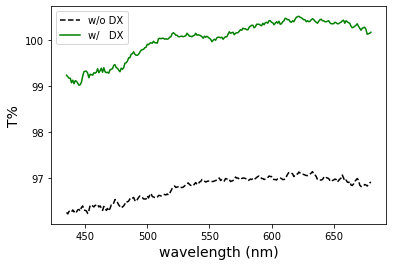

In [12]:
T_LOCA_GG3 = trans(1.51, 1.41)
GG3 = pd.read_csv("./DX/Glass_0T.csv")
wl_GG3 = np.linspace(380, 800, 421)
T_GG3 = np.array([float(i) for i in GG3["SCAN"]])
T_GG3_2 = sec_reflec(T_GG3, 1, 1.51)
DX = pd.read_csv("./DX/DX-MP-1_0T.csv")
T_DX = np.array([float(i) for i in DX["SCAN"]])
T_DX_2 = sec_reflec(T_DX, 1, 1.51)
#plt.plot(wl_ITO, T_GG3[55:-120], "k--",label = "w/o DX")
#plt.plot(wl_GG3, T_GG3_2*100)
#plt.show()
#plt.plot(wl_ITO, T_DX[55:-120], "g",label = "w/   DX")
#plt.plot(wl_GG3, T_DX_2*100)

#plt.show()
plt.plot(wl_ITO, T_GG3_2[55:-120]*100, "k--",label = "w/o DX")
plt.plot(wl_ITO, T_DX_2[55:-120]*100, "g",label = "w/   DX")
plt.ylabel("T%", fontsize = 14)
plt.xlabel("wavelength (nm)", fontsize = 14)
plt.legend(loc = "best")
plt.savefig("GG32.png")
plt.show()
# [55:-120]

In [13]:
T0_GG3 = T_LOCA_GG3 * T_GG3_2[55:-120]
T0_DX = T_LOCA_GG3 * T_DX_2[55:-120]

In [15]:
d1 = 2005.69375874
d2 = 17.25556131
d3 = 51.58391126
d4 = 23.82453004
d5 = 59.27267042
d6 = 3.96078843

start_wl = 435
end_wl = 680
wl_ITO = np.linspace(start_wl, end_wl, end_wl - start_wl+1)
bridge = ThinFilm_model(
    {'a': 'LOCA'}, [
        {'m': 'Acrylic', 'd': 800},
        {'m': 'SiN', 'd': d2},
        {'m': 'SiO2', 'd':d3},
        {'m': 'ITO', 'd': d4},
        {'m': 'Acrylic', 'd':1200},
        {'m': 'ITO', 'd':d4},
        {'m': 'SiO2', 'd':d5},
        {'m': 'SiN', 'd': d6}
    ], {'s': 'sodalime'}, wl_ITO, 5)

ITO_layer = ThinFilm_model(
    {'a': 'LOCA'}, [
        {'m': 'Acrylic', 'd': d1},
        {'m': 'SiN', 'd': d2},
        {'m': 'SiO2', 'd':d3},
        {'m': 'ITO', 'd':d4},
        {'m': 'SiO2', 'd':d5},
        {'m': 'SiN', 'd': d6}
    ], {'s': 'sodalime'}, wl_ITO, 5)

pattern = ThinFilm_model(
    {'a': 'LOCA'}, [
        {'m': 'Acrylic', 'd': d1},
        {'m': 'SiN', 'd': d2},
        {'m': 'SiO2', 'd':d3},
        {'m': 'SiO2', 'd':d5},
        {'m': 'SiN', 'd': d6}
    ], {'s': 'sodalime'}, wl_ITO, 5)

R_b = bridge.R()
R_ITO = ITO_layer.R()
#R_p = pattern.R()

dR = abs(R_b-R_ITO)
plt.plot(wl_ITO, dR, 'k--',label = "w/o DX")
plt.plot(wl_ITO, dR, 'g',label = "w/   DX")
#plt.plot(wl_ITO, R_b, 'r',label = 'bridge')
#plt.plot(wl_ITO, R_ITO, 'y', label = 'diamond')
#plt.plot(wl_ITO, dR, 'k--', label = 'delta R')

#plt.plot(wl_ITO, R_p, 'b', label = 'pattern')
plt.ylabel("R", fontsize = 14)
plt.xlabel("wavelength (nm)", fontsize = 14)
plt.legend(loc = "best")
plt.savefig("hhOC.png")
print(mean(dR))
plt.show()

KeyError: "None of [Index(['type', 'material'], dtype='object')] are in the [columns]"

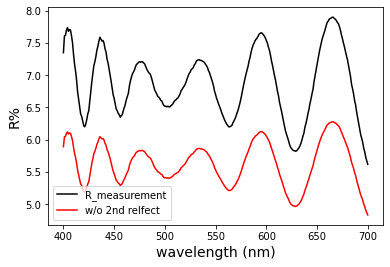

In [25]:
ITO_R = pd.read_csv("./mearsurement/R_5.csv")
wl_R = np.linspace(400,700,301)
RR = [float(i) for i in ITO_R['SCAN']]
MB =  ThinFilm_model(
    {'a': 'air'}, [
    ], {'s': 'sodalime'}, wl_R, 5)
RB = MB.R()
RA = (RR-RB)/(1+RR*RB-2*RB)
plt.ylabel("R%", fontsize = 14)
plt.xlabel("wavelength (nm)", fontsize = 14)
plt.plot(wl_R, RR, "k",label = "R_measurement")
plt.plot(wl_R, RA, "r",label = "w/o 2nd relfect")
plt.legend(loc = "best")
#plt.savefig("test.png")
plt.show()

In [17]:
def opt(x):
    d1 = x[0]
    d2 = x[1]
    d3 = x[2]
    d4 = x[3]
    d5 = x[4]
    d6 = x[5]
    wl_ITO = np.linspace(435,680,246)
    diamond = ThinFilm_model(
        {'a': 'air'}, [
            {'m': 'acrylic', 'd': d6},
            {'m': 'SiN', 'd': d1},
            {'m': 'SiO2', 'd':d2},
            {'m': 'ITO', 'd': d3},
            {'m': 'SiO2', 'd':d4},
            {'m': 'SiN', 'd': d5}
        ], {'s': 'sodalime'}, wl_ITO, 5)
    R_d = diamond.R()
    fm = sum((100*R_d - RA[35:-20])**2)
    return fm

In [74]:
d1 = 12
d2 = 60
d3 = 23
d4 = 60
d5 = 12
d6 = 2000
least_squares(opt, [d1,d2,d3,d4,d5,d6])

 active_mask: array([0., 0., 0., 0., 0., 0.])
        cost: 60429.18587976755
         fun: array([347.64690673])
        grad: array([  76.49644438,   95.37003958, -154.33133642,   42.11660261,
         17.87693217, -135.84496004])
         jac: array([[ 0.22004063,  0.27433018, -0.44393128,  0.12114764,  0.05142267,
        -0.39075556]])
     message: '`xtol` termination condition is satisfied.'
        nfev: 258
        njev: 237
  optimality: 154.3313364237696
      status: 3
     success: True
           x: array([  17.25556131,   51.58391126,   23.82453004,   59.27267042,
          3.96078843, 2005.69375874])

1.3901795748831063


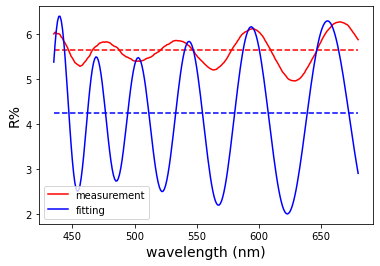

In [96]:
wl_ITO = np.linspace(435,680,246)
diamond = ThinFilm_model(
        {'a': 'air'}, [
            {'m': 'acrylic', 'd': 2005.69375874},
            {'m': 'SiN', 'd': 17.25556131},
            {'m': 'SiO2', 'd': 51.58391126},
            {'m': 'ITO', 'd': 23.82453004},
            {'m': 'SiO2', 'd': 59.27267042},
            {'m': 'SiN', 'd': 3.96078843}
        ], {'s': 'sodalime'}, wl_ITO, 5)
R_d = diamond.R()
Ra = RA[35:-20]
plt.plot(wl_ITO, Ra, 'r-' ,label = 'measurement')
plt.plot(wl_ITO, mean(Ra)*np.ones(np.size(wl_ITO)), 'r--')
plt.plot(wl_ITO, 100*R_d, 'b-' ,label = 'fitting')
plt.plot(wl_ITO, 100*mean(R_d)*np.ones(np.size(wl_ITO)), 'b--')
plt.ylabel("R%", fontsize = 14)
plt.xlabel("wavelength (nm)", fontsize = 14)
plt.legend(loc = "best")
print(mean(Ra)-100*mean(R_d))
plt.show()